In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import random
import math

import torch
from torch import nn, optim
import torch.nn.functional as F
from collections import deque

In [150]:
## hyper parameters

episodes = 100
e_start = 0.9
e_end = 0.05
e_decay = 200
gamma = 0.8
lr = 0.001
batch_size = 64

In [29]:
class DQN_Acrobot(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.step = 0
        self.deque = deque(maxlen=1000)

    def memorize(self, state, action, reward, next_state):
        self.deque.append((state,
                           action,
                           torch.FloatTensor([reward]),
                           torch.FloatTensor([next_state])
                           ))
    
    def action(self, state):
        eps_theta = e_end + (e_start - e_end)*np.exp(-(self.step/e_decay))
        self.step += 1
        if np.random.rand() < eps_theta:
            return torch.LongTensor([[np.random.choice([0, 1])]])
        else:
            return self.model(state).data.argmax().view(1, 1)
        
    def learning(self):
        if len(self.deque) < batch_size*4:
            return
        batch = random.sample(self.deque, batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (gamma*max_next_q)

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [151]:
env = gym.make('Acrobot-v1')
# env = gym.make('Acrobot-v1', render_mode='human')
agent = DQN_Acrobot()
scores = []

Episode: 1 / episode_len: 500
Episode: 2 / episode_len: 500
Episode: 3 / episode_len: 500
Episode: 4 / episode_len: 500
Episode: 5 / episode_len: 500
Episode: 6 / episode_len: 500
Episode: 7 / episode_len: 500
Episode: 8 / episode_len: 500
Episode: 9 / episode_len: 500
Episode: 10 / episode_len: 500
Episode: 11 / episode_len: 500
Episode: 12 / episode_len: 500
Episode: 13 / episode_len: 500
Episode: 14 / episode_len: 500
Episode: 15 / episode_len: 500
Episode: 16 / episode_len: 500
Episode: 17 / episode_len: 500
Episode: 18 / episode_len: 488
Episode: 19 / episode_len: 329
Episode: 20 / episode_len: 331
Episode: 21 / episode_len: 270
Episode: 22 / episode_len: 177
Episode: 23 / episode_len: 500
Episode: 24 / episode_len: 176
Episode: 25 / episode_len: 299
Episode: 26 / episode_len: 500
Episode: 27 / episode_len: 307
Episode: 28 / episode_len: 426
Episode: 29 / episode_len: 500
Episode: 30 / episode_len: 335
Episode: 31 / episode_len: 500
Episode: 32 / episode_len: 500
Episode: 33 / epi

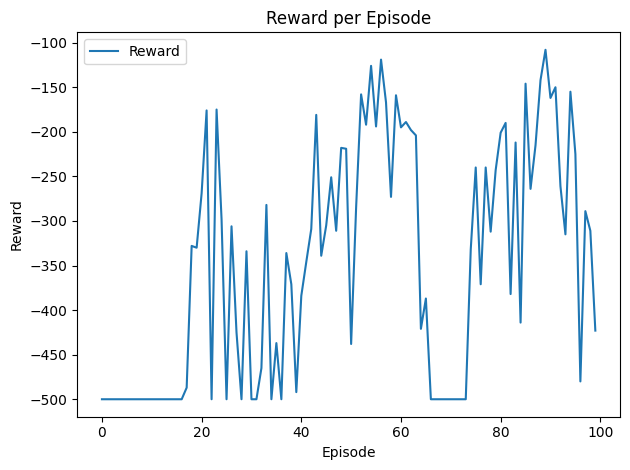

In [152]:
for i in range(1, episodes+1):
    if episodes - i < 1:
        env = gym.make('Acrobot-v1', render_mode='human')
    state, _ = env.reset()
    episode_len = 0
    score = 0

    while True:
        state = torch.FloatTensor([state])
        action = agent.action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        agent.memorize(state, action, reward, next_state)
        agent.learning()

        state = next_state
        episode_len += 1
        score += reward

        # print(f"episode_len = {episode_len}, {terminated}, {truncated}")
        
        if terminated or truncated:
            print(f"Episode: {i} / episode_len: {episode_len}")
            scores.append(score)

            # reward graph
            plt.clf()
            plt.plot(scores, label="Reward")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.title("Reward per Episode")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"Acrobot_DQN_reward.png")

            break

env.close()

In [143]:
env.close()

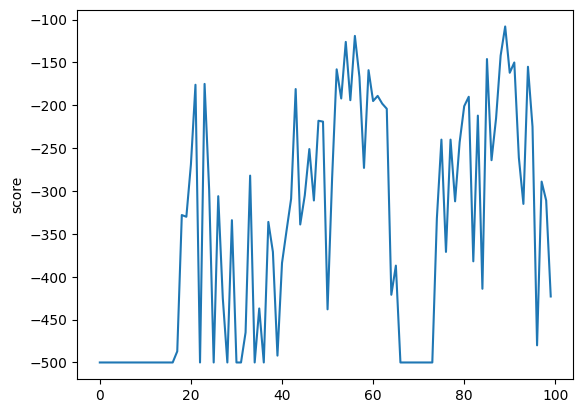

In [153]:
plt.plot(scores)
plt.ylabel('score')
plt.show()